In [1]:
from datasets import load_from_disk
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
project_root = Path.cwd().parent
data_path_1 = project_root / "data" / "train"
data_path_2 = project_root / "data" / "test"
data_path_3 = project_root / "data" / "validation"

train = load_from_disk(str(data_path_1))
test = load_from_disk(str(data_path_2))
validation = load_from_disk(str(data_path_3))

In [ ]:
train_df = pd.DataFrame(train) 

C:\Users\lukas\AppData\Roaming\Python\Python311\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


# Allgemeiner Überblick

In [4]:
counts = {
    "Train"     : len(train),
    "Validation": len(validation),
    "Test"      : len(test)
}
for split, cnt in counts.items():
    print(f"{split}: {cnt} Beispiele")

Train: 19654 Beispiele
Validation: 6259 Beispiele
Test: 6719 Beispiele


In [5]:
# Anzahl einzigartiger Bilder pro Split
def count_unique_images(ds):
    # Nutzt, falls vorhanden, den Dateipfad; sonst Bildbytes-Hash
    paths = [getattr(img, "path", None) for img in ds["image"]]
    if all(p is not None for p in paths):          # Pfade vorhanden
        return len(set(paths))
    else:
        import hashlib
        hashes = [hashlib.md5(img.tobytes()).hexdigest() for img in ds["image"]]
        return len(set(hashes))

print("Einzigartige Bilder Train:", count_unique_images(train))
print("Einzigartige Bilder Test:", count_unique_images(test))
print("Einzigartige Bilder Validation:", count_unique_images(validation))

C:\Users\lukas\AppData\Roaming\Python\Python311\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Einzigartige Bilder Train: 2599
Einzigartige Bilder Test: 858
Einzigartige Bilder Validation: 832


In [6]:
# Verteilung Bilder ↔ Fragen in jedem Split
def questions_per_image(ds):
    paths = [getattr(img, "path", idx) for idx, img in enumerate(ds["image"])]
    from collections import Counter
    return Counter(paths)

for name, ds in [("Train", train), ("Test", test), ("Validation", validation)]:
    qpi = questions_per_image(ds)
    print(f"{name}: Ø {sum(qpi.values())/len(qpi):.2f} Fragen pro Bild")

Train: Ø 1.00 Fragen pro Bild
Test: Ø 1.00 Fragen pro Bild
Validation: Ø 1.00 Fragen pro Bild


# Strukturelle Analyse

In [7]:
# Datentypen laut HF-Datasets-Schema
print(train.features)          # zeigt alle Spalten + Typen


{'image': Image(mode=None, decode=True, id=None), 'question': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None)}


In [8]:
from collections import Counter
import numpy as np

def missing_stats(ds, col):
    """Zählt leere Strings, None und NaN."""
    empty = 0
    for v in ds[col]:
        if v is None or (isinstance(v, str) and v.strip() == '') \
                     or (isinstance(v, float) and np.isnan(v)):
            empty += 1
    return empty, empty/len(ds)

for split_name, split_ds in [("Train", train), ("Test", test), ("Validation", validation)]:
    for col in ["image", "question", "answer"]:
        miss_abs, miss_rel = missing_stats(split_ds, col)
        print(f"{split_name:<11} {col:<8}: {miss_abs:5d} fehlend  ({miss_rel:.2%})")


Train       image   :     0 fehlend  (0.00%)
Train       question:     0 fehlend  (0.00%)
Train       answer  :     0 fehlend  (0.00%)
Test        image   :     0 fehlend  (0.00%)
Test        question:     0 fehlend  (0.00%)
Test        answer  :     0 fehlend  (0.00%)
Validation  image   :     0 fehlend  (0.00%)
Validation  question:     0 fehlend  (0.00%)
Validation  answer  :     0 fehlend  (0.00%)


# Analyse der Fragen

In [14]:
import re
from collections import Counter

def classify_question(q: str) -> str:
    """
    Very simple rule-based detection for English questions.
    Returns one of {'yes_no', 'numeric', 'open'}.
    """
    q_lower = q.lower().strip()

    # yes/no pattern → starts with auxiliary / modal verb
    if re.match(r"^(is|are|was|were|do|does|did|has|have|had|can|could|will|would|should)\b", q_lower):
        return "yes_no"

    # numeric pattern → contains at least one digit
    if re.search(r"\d", q_lower):
        return "numeric"

    return "open"

for name, ds in [("Train", train), ("Test", test), ("Validation", validation)]:
    types = Counter(classify_question(q) for q in ds["question"])
    total = sum(types.values())
    print(f"\n{name}:")
    for t, c in types.items():
        print(f"  {t:<8}: {c:5d}  ({c/total:.1%})")



Train:
  open    :  9847  (50.1%)
  numeric :    58  (0.3%)
  yes_no  :  9749  (49.6%)

Test:
  open    :  3328  (49.5%)
  yes_no  :  3361  (50.0%)
  numeric :    30  (0.4%)

Validation:
  open    :  3101  (49.5%)
  yes_no  :  3125  (49.9%)
  numeric :    33  (0.5%)


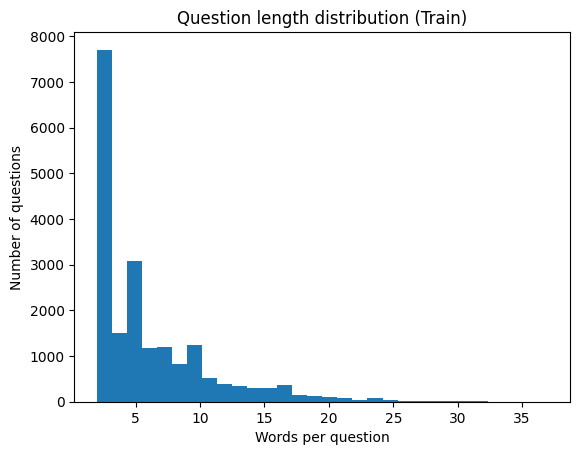

In [15]:
import matplotlib.pyplot as plt

def q_len_words(q): return len(q.split())
def q_len_sents(q): return q.count("?") + q.count(".") + q.count("!")

lengths_words = [q_len_words(q) for q in train["question"]]

plt.hist(lengths_words, bins=30)
plt.xlabel("Words per question")
plt.ylabel("Number of questions")
plt.title("Question length distribution (Train)")
plt.show()


# Analyse der Antworten

In [18]:
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt


In [19]:
def classify_answer(ans: str) -> str:
    """
    Very simple rule set for answer classes.
    Returns one of {'yes_no', 'numeric', 'free'}.
    """
    a = ans.strip().lower()
    if a in {"yes", "no"}:
        return "yes_no"
    # numeric if it contains at least one digit OR is parseable as float
    if re.search(r"\d", a):
        return "numeric"
    try:
        float(a)
        return "numeric"
    except ValueError:
        pass
    return "free"


In [20]:
splits = {"Train": train, "Test": test, "Validation": validation}

results = defaultdict(dict)

for split_name, ds in splits.items():
    # Verteilung der Antworttypen
    types = Counter(classify_answer(a) for a in ds["answer"])
    results[split_name]["type_dist"] = types

    # Anzahl eindeutiger Antworten
    uniq = len(set(ds["answer"]))
    results[split_name]["n_unique"] = uniq

    # Top-20 Antworten
    top20 = Counter(ds["answer"]).most_common(20)
    results[split_name]["top20"] = top20

    # Antwortlaengen in Tokens (Wortanzahl)
    lengths = [len(a.split()) for a in ds["answer"]]
    results[split_name]["lengths"] = lengths

    # Mapping Frage-→Antworttyp (Imbalance Check)
    qa = Counter(
        (classify_question(q), classify_answer(a))
        for q, a in zip(ds["question"], ds["answer"])
    )
    results[split_name]["qa_matrix"] = qa

# Kurzreport in der Konsole
for split, d in results.items():
    print(f"\n=== {split} ===")
    total = sum(d["type_dist"].values())
    for t, c in d["type_dist"].items():
        print(f"{t:<8}: {c:5d}  ({c/total:.1%})")
    print("Unique answers:", d["n_unique"])
    print("Top-5:", d["top20"][:5])



=== Train ===
free    :  9792  (49.8%)
yes_no  :  9751  (49.6%)
numeric :   111  (0.6%)
Unique answers: 3225
Top-5: [('yes', 5378), ('no', 4373), ('oral', 370), ('cardiovascular', 308), ('hematologic', 266)]

=== Test ===
free    :  3317  (49.4%)
yes_no  :  3362  (50.0%)
numeric :    40  (0.6%)
Unique answers: 1300
Top-5: [('yes', 1816), ('no', 1546), ('cardiovascular', 128), ('endocrine', 96), ('oral', 89)]

=== Validation ===
free    :  3088  (49.3%)
yes_no  :  3125  (49.9%)
numeric :    46  (0.7%)
Unique answers: 1215
Top-5: [('yes', 1712), ('no', 1413), ('oral', 117), ('hepatobiliary', 100), ('cardiovascular', 98)]


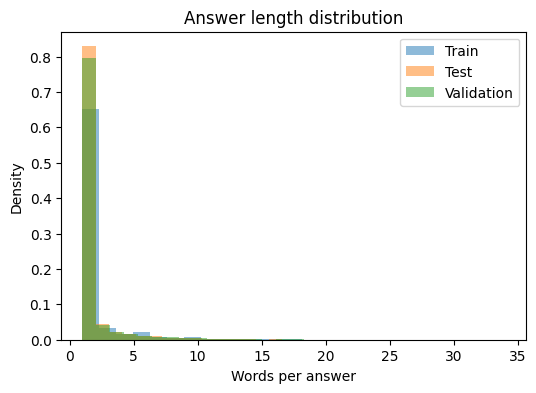

In [21]:
plt.figure(figsize=(6,4))
for split, d in results.items():
    plt.hist(d["lengths"], bins=25, alpha=0.5, label=split, density=True)
plt.xlabel("Words per answer")
plt.ylabel("Density")
plt.title("Answer length distribution")
plt.legend()
plt.show()


In [22]:
import pandas as pd

for split, d in results.items():
    # baue eine 3x3 Matrix question_type x answer_type
    mat = defaultdict(int)
    for (qtype, atype), cnt in d["qa_matrix"].items():
        mat[(qtype, atype)] += cnt
    df = (
        pd.Series(mat)
        .unstack(level=0)        # Spalten = question types
        .fillna(0)
        .astype(int)
        .T                       # nicer orientation: rows = question
    )
    print(f"\nConfusion table {split}:")
    display(df)                  # Jupyter: zeigt hübsche Tabelle



Confusion table Train:


,free,numeric,yes_no
numeric,53,5,0
open,9737,106,4
yes_no,2,0,9747



Confusion table Test:


,free,numeric,yes_no
numeric,23,7,0
open,3293,33,2
yes_no,1,0,3360



Confusion table Validation:


,free,numeric,yes_no
numeric,29,4,0
open,3052,42,7
yes_no,7,0,3118


In [23]:
for split, d in results.items():
    yn = d["type_dist"]["yes_no"]
    yes_cnt = sum(1 for a in splits[split]["answer"] if a.lower() == "yes")
    no_cnt  = sum(1 for a in splits[split]["answer"] if a.lower() == "no")
    if yes_cnt + no_cnt:
        ratio = yes_cnt / (yes_cnt + no_cnt)
        print(f"{split}: yes answers = {ratio:.1%} of all yes/no")
    else:
        print(f"{split}: no yes/no answers detected")


Train: yes answers = 55.2% of all yes/no
Test: yes answers = 54.0% of all yes/no
Validation: yes answers = 54.8% of all yes/no


Train: Ø 7.56 Fragen pro Bild, Max 32
Test: Ø 7.83 Fragen pro Bild, Max 28
Validation: Ø 7.52 Fragen pro Bild, Max 32


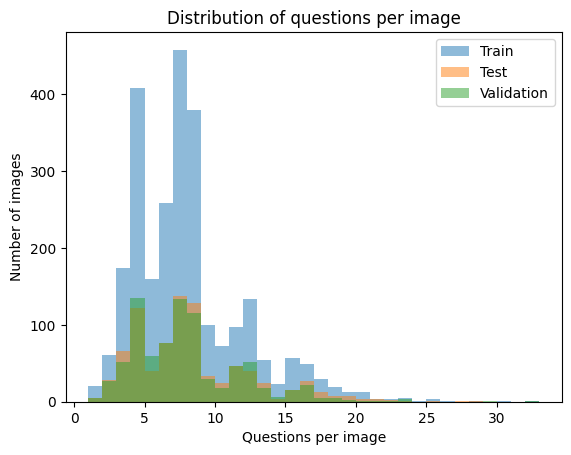

In [29]:
from collections import Counter

def questions_per_image(ds):
    return Counter(image_hash(im) for im in ds["image"])

for name, ds in splits.items():
    qpi = questions_per_image(ds)
    values = list(qpi.values())
    print(f"{name}: Ø {np.mean(values):.2f} Fragen pro Bild, Max {max(values)}")
    plt.hist(values, bins=range(1, max(values)+2), alpha=0.5, label=name)

plt.xlabel("Questions per image")
plt.ylabel("Number of images")
plt.title("Distribution of questions per image")
plt.legend()
plt.show()


# Frage-Antwort Beziehungen und Korrelationen

In [30]:
import re, itertools, random, math, tqdm, hashlib
import numpy as np, pandas as pd
from collections import Counter, defaultdict
from scipy.stats import chi2_contingency, pearsonr

In [31]:
def q_len(q): return len(q.split())
def a_len(a): return len(a.split())

for name, ds in [("Train", train), ("Test", test), ("Validation", validation)]:
    ql = np.array([q_len(q) for q in ds["question"]])
    al = np.array([a_len(a) for a in ds["answer"]])
    r, p = pearsonr(ql, al)
    print(f"{name}: r={r:.3f},  p={p:.2e}  (n={len(ds)})")


Train: r=0.009,  p=1.98e-01  (n=19654)
Test: r=0.016,  p=1.79e-01  (n=6719)
Validation: r=0.006,  p=6.24e-01  (n=6259)


In [32]:
def classify_q(q):   # wie zuvor
    q_lower = q.lower()
    if re.match(r"^(is|are|was|were|do|does|did|has|have|had|can|could|will|would|should)\b", q_lower):
        return "yes_no"
    if re.search(r"\d", q_lower):
        return "numeric"
    return "open"

def classify_a(a):   # wie zuvor
    a_lower = a.lower()
    if a_lower in {"yes", "no"}:        return "yes_no"
    if re.search(r"\d", a_lower):       return "numeric"
    try: float(a_lower); return "numeric"
    except: return "free"

for name, ds in [("Train", train), ("Test", test), ("Validation", validation)]:
    mat = pd.crosstab(
        pd.Series([classify_q(q) for q in ds["question"]], name="qtype"),
        pd.Series([classify_a(a) for a in ds["answer"]],   name="atype")
    )
    chi2, p, dof, _ = chi2_contingency(mat)
    print(f"\n{name} chi²={chi2:.1f} (dof={dof}), p={p:.2e}")
    display(mat)



Train chi²=19688.8 (dof=4), p=0.00e+00


atype,free,numeric,yes_no
qtype,,,
numeric,53,5,0
open,9737,106,4
yes_no,2,0,9747



Test chi²=6959.3 (dof=4), p=0.00e+00


atype,free,numeric,yes_no
qtype,,,
numeric,23,7,0
open,3293,33,2
yes_no,1,0,3360



Validation chi²=6255.4 (dof=4), p=0.00e+00


atype,free,numeric,yes_no
qtype,,,
numeric,29,4,0
open,3052,42,7
yes_no,7,0,3118


In [33]:
def contains_image(q): return "image" in q.lower()

for name, ds in [("Train", train), ("Test", test), ("Validation", validation)]:
    mask_yesno = [classify_q(q)=="yes_no" for q in ds["question"]]
    qs = np.array(ds["question"])[mask_yesno]
    ans = np.array(ds["answer"])[mask_yesno]
    image_mask = np.array([contains_image(q) for q in qs])
    
    yes_with_image = np.sum((ans[image_mask] == "yes") | (ans[image_mask] == "Yes"))
    total_with_image = image_mask.sum()
    print(f"{name}: P(yes | 'image' in question) = {yes_with_image/total_with_image:.1%} "
          f"({yes_with_image}/{total_with_image})")


Train: P(yes | 'image' in question) = 98.8% (1779/1800)
Test: P(yes | 'image' in question) = 97.6% (605/620)
Validation: P(yes | 'image' in question) = 98.3% (573/583)


In [34]:
q_to_imgs = defaultdict(set)
for ds in [train, test, validation]:
    for q, img in zip(ds["question"], ds["image"]):
        q_to_imgs[q].add(hashlib.md5(img.tobytes()).hexdigest())

multi_img_questions = {q:imgs for q, imgs in q_to_imgs.items() if len(imgs) > 1}
print(f"{len(multi_img_questions)} unique questions appear on >1 image")


C:\Users\lukas\AppData\Roaming\Python\Python311\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1542 unique questions appear on >1 image
